In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [42]:
def json_to_df(path_or_obj):
    # Accept either a filepath (str) or already-loaded Python dict
    if isinstance(path_or_obj, str):
        with open(path_or_obj, "r", encoding="utf-8") as f:
            data = json.load(f)
    else:
        data = path_or_obj

    rows = []
    for date_str, payload in data.items():
        results = (payload or {}).get("results", {}) or {}
        for industry, info in results.items():
            rows.append({
                "date": pd.to_datetime(date_str, format="%Y%m%d", errors="coerce"),
                "industry": industry,
                "score": (info or {}).get("score")
            })

    df = pd.DataFrame(rows, columns=["date", "industry", "score"])
    df = df.dropna(subset=["date"]).sort_values(["date", "industry"]).reset_index(drop=True)
    return df

sentiments = json_to_df("/Users/edwardju/Downloads/chinese-stock-market/data/industry_sentiment.json")
tot = sentiments.groupby("date")["score"].transform(lambda s: s.abs().sum())
sentiments["tot_score"] = tot
sentiments["norm_score"] = sentiments["score"].div(tot).where(tot.ne(0))
sentiments.head()

,date,industry,score,tot_score,norm_score
0,2015-01-01,Agriculture,30,280,0.107143
1,2015-01-01,Air Transport,0,280,0.000000
2,2015-01-01,Animal Husbandry,10,280,0.035714
3,2015-01-01,Art Industry,20,280,0.071429
4,2015-01-01,Banking,0,280,0.000000


In [43]:
mean_scores = pd.DataFrame(sentiments.groupby('industry')['score'].mean().sort_values(ascending=False))
mean_scores[mean_scores.index.str.contains('Art')]

,score
industry,
Art Industry,10.01391


In [44]:
d = sentiments["date"]
s = sentiments["score"].astype(float)

n = s.groupby(d).transform("size")
k = np.ceil(0.1 * n).astype(int)

neg = s.groupby(d).rank(method="first", ascending=True) <= k
pos = s.groupby(d).rank(method="first", ascending=False) <= k

pos_den = s.where(pos, 0).groupby(d).transform("sum")
neg_den_abs = s.abs().where(neg, 0).groupby(d).transform("sum")
neg_cnt = neg.groupby(d).transform("sum")

sentiments["tail_norm"] = 0.0

# Normal: positives sum to +1 (when pos_den != 0)
pos_ok = pos & pos_den.ne(0) & s.notna()
sentiments.loc[pos_ok, "tail_norm"] = s[pos_ok] / pos_den[pos_ok]

# Normal: negatives sum to -1 via abs-weight (when neg_den_abs != 0)
neg_ok = neg & neg_den_abs.ne(0) & s.notna()
sentiments.loc[neg_ok, "tail_norm"] = -s.abs()[neg_ok] / neg_den_abs[neg_ok]

# Fallback: if selected negatives are all 0, split -1 equally across them
neg_fb = neg & neg_den_abs.eq(0) & neg_cnt.gt(0)
sentiments.loc[neg_fb, "tail_norm"] = -1.0 / neg_cnt[neg_fb]
sentiments.head()

,date,industry,score,tot_score,norm_score,tail_norm
0,2015-01-01,Agriculture,30,280,0.107143,0.150
1,2015-01-01,Air Transport,0,280,0.000000,-0.125
2,2015-01-01,Animal Husbandry,10,280,0.035714,0.000
3,2015-01-01,Art Industry,20,280,0.071429,0.100
4,2015-01-01,Banking,0,280,0.000000,-0.125


In [45]:
check = sentiments.groupby("date")["norm_score"].agg(
    pos_sum=lambda x: x[x>0].sum(),
    neg_sum=lambda x: x[x<0].sum()
)
print(check.mean())

pos_sum    0.965032
neg_sum   -0.034968
dtype: float64


In [46]:
# def add_exp_decay_sentiment(df, col="score", id_col="industry", date_col="date",
#                             half_life_days=5):
#     d = df.copy()
#     d[date_col] = pd.to_datetime(d[date_col])
#     d = d.sort_values([id_col, date_col])

#     # Half-life -> span for pandas EWM (exponentially weighted moving)
#     alpha = 1 - np.exp(np.log(0.5) / half_life_days)      # daily decay rate
#     span = (2 / alpha) - 1                                # convert alpha <-> span

#     d["sent_ewma"] = (
#         d.groupby(id_col, group_keys=False)[col]
#          .apply(lambda s: s.ewm(span=span, adjust=False, min_periods=1).mean())
#     )

#     # Optional: lag so you only use info available before trading the day
#     d["sent_ewma_lag1"] = d.groupby(id_col)["sent_ewma"].shift(1)
    
#     s = d["sent_ewma_lag1"]
#     s = s - s.groupby(d["date"]).transform("mean")  # de-mean per day
#     abs_sum = s.abs().groupby(d["date"]).transform("sum")
#     d["w_ls"] = s / abs_sum
#     return d

# sentiments_decay = add_exp_decay_sentiment(sentiments, col='tail_norm', id_col='industry', half_life_days=5)
# sentiments_decay.head()

# Raw sentiment weights (no EWMA)
def add_raw_sentiment_weights(df, col="score", date_col="date"):
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col])
    
    # weight = score / sum(abs(scores)) per day
    abs_sum = d.groupby(date_col)[col].transform(lambda x: x.abs().sum())
    d["w_ls"] = d[col] / abs_sum
    return d

sentiments_decay = add_raw_sentiment_weights(sentiments, col='score')
sentiments_decay.head()

,date,industry,score,tot_score,norm_score,tail_norm,w_ls
0,2015-01-01,Agriculture,30,280,0.107143,0.150,0.107143
1,2015-01-01,Air Transport,0,280,0.000000,-0.125,0.000000
2,2015-01-01,Animal Husbandry,10,280,0.035714,0.000,0.035714
3,2015-01-01,Art Industry,20,280,0.071429,0.100,0.071429
4,2015-01-01,Banking,0,280,0.000000,-0.125,0.000000


In [47]:
check = sentiments_decay.groupby("date")["w_ls"].agg(
    pos_sum=lambda x: x[x>0].sum(),
    neg_sum=lambda x: x[x<0].sum()
)
print(check.mean())


pos_sum    0.965032
neg_sum   -0.034968
dtype: float64


In [48]:
normal_sentiments = sentiments[['date', 'industry', 'norm_score']]
tail_sentiments = sentiments[['date', 'industry', 'tail_norm']]
tail_sentiments[['tail_norm']] /= 2
tail_sentiments["tail_norm_trailing"] = (
    tail_sentiments.groupby("industry")["tail_norm"]
    .transform(lambda s: s.rolling(30).mean().shift(1))
)
tail_sentiments = tail_sentiments.dropna(subset=["tail_norm_trailing"]).copy()
tail_sentiments.head()

/var/folders/cm/n391pt213xv2t590fn6lcrph0000gn/T/ipykernel_58837/2417577494.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail_sentiments[['tail_norm']] /= 2
/var/folders/cm/n391pt213xv2t590fn6lcrph0000gn/T/ipykernel_58837/2417577494.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail_sentiments["tail_norm_trailing"] = (


,date,industry,tail_norm,tail_norm_trailing
2130,2015-01-31,Agriculture,0.058824,0.057256
2131,2015-01-31,Air Transport,-0.200000,-0.027317
2132,2015-01-31,Animal Husbandry,-0.000000,-0.026080
2133,2015-01-31,Art Industry,0.000000,0.026923
2134,2015-01-31,Banking,-0.000000,0.004765


In [49]:
daily_rets = pd.read_csv("/Users/edwardju/Downloads/CSMAR Daily Stock Return/TRD_Daily_full_20010101_20231201.csv",usecols=['Stkcd', 'Trddt', 'Dsmvtll', 'Dretwd'])
daily_rets.columns = ['stockid', 'date', 'tot_mv', 'returns']
daily_rets['date'] = pd.to_datetime(daily_rets['date'], format='%Y-%m-%d')
daily_rets.head()

,stockid,date,tot_mv,returns
0,1,2016-01-04,1.621173e+08,-0.055046
1,1,2016-01-05,1.631189e+08,0.006178
2,1,2016-01-06,1.649790e+08,0.011404
3,1,2016-01-07,1.565369e+08,-0.051171
4,1,2016-01-08,1.591125e+08,0.016453


In [50]:
co_ind = pd.read_csv("/Users/edwardju/Downloads/CSMAR Daily Stock Return/TRD_Co.csv", encoding='cp1252', usecols=['Stkcd', 'Nindnme_en'])
co_ind.columns=['stockid', 'industry']
daily_rets = daily_rets.merge(co_ind, on=['stockid'], how='left')
daily_rets.head()

,stockid,date,tot_mv,returns,industry
0,1,2016-01-04,1.621173e+08,-0.055046,Banking
1,1,2016-01-05,1.631189e+08,0.006178,Banking
2,1,2016-01-06,1.649790e+08,0.011404,Banking
3,1,2016-01-07,1.565369e+08,-0.051171,Banking
4,1,2016-01-08,1.591125e+08,0.016453,Banking


In [51]:
def keep_top_quartile_mv_by_industry(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d["date"] = pd.to_datetime(d["date"])
    d = d.dropna(subset=["stockid", "date", "tot_mv", "industry"])
    d = d.sort_values(["date", "industry", "stockid"])

    # within each (date, industry), keep stocks with MV >= 75th percentile
    q75 = d.groupby(["date", "industry"])["tot_mv"].transform(lambda s: s.quantile(0.90))
    return d[d["tot_mv"] >= q75].reset_index(drop=True)

# usage
daily_rets = keep_top_quartile_mv_by_industry(daily_rets)


In [52]:
def make_industry_portfolios(df):
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])

    # clean + make safe weights
    df["tot_mv"] = pd.to_numeric(df["tot_mv"], errors="coerce")
    df["returns"] = pd.to_numeric(df["returns"], errors="coerce")

    df["mv_x_ret"] = df["tot_mv"] * df["returns"]

    out = (df.groupby(["date", "industry"], as_index=False)
            .agg(industry_tot_mv=("tot_mv", "sum"),
                mv_x_ret=("mv_x_ret", "sum")))

    # value-weighted industry return; NaN if industry_tot_mv==0
    out["industry_ret"] = out["mv_x_ret"].div(out["industry_tot_mv"]).where(out["industry_tot_mv"].ne(0))

    out = out[["date", "industry", "industry_ret", "industry_tot_mv"]].sort_values(["date", "industry"])
    return out

indus_portfolios = make_industry_portfolios(daily_rets)
indus_portfolios.head()

,date,industry,industry_ret,industry_tot_mv
0,2001-01-02,Agriculture,0.019446,7716478.51
1,2001-01-02,Air Transport,0.016071,18777000.00
2,2001-01-02,Animal Husbandry,0.004651,4209874.56
3,2001-01-02,Art Industry,0.015674,2247264.00
4,2001-01-02,Banking,0.008193,50417200.00


In [53]:
indus_portfolios[indus_portfolios['date'] >= pd.to_datetime('2015-01-01')].groupby('industry')['industry_ret'].mean().sort_values()

industry
Forestry                                                                -0.000133
Rental and Leasing Services                                             -0.000071
Oil and Gas Extraction                                                   0.000087
Warehousing                                                              0.000117
Railroad Transport                                                       0.000200
                                                                           ...   
Animal Husbandry                                                         0.002083
Furs, Leather, Feather and Related Products Manufacturing                0.002107
Computer Application Service                                             0.002122
Instruments and Apparatus, Culture and Office Machinery Manufacturing    0.002272
Nonmetallic Mineral Mining and Quarrying                                 0.002450
Name: industry_ret, Length: 71, dtype: float64

In [54]:
# import statsmodels.api as sm

# indus_ret_senti = pd.merge(indus_portfolios, sentiments_decay, on=['date', 'industry'], how='inner')
# # df columns needed: date, industry, industry_ret (today), sent_ewma (today's signal)
# d = indus_ret_senti.copy()
# d["date"] = pd.to_datetime(d["date"])
# d = d.sort_values(["industry","date"])

# # X = yesterday sentiment, y = tomorrow return
# d["sent_lag1"] = d.groupby("industry")["sent_ewma"].shift(1)
# # d["ret"]  = d.groupby("industry")["industry_ret"].shift(-1)
# d = d.dropna(subset=["sent_lag1","industry_ret"])

# # --- Option A: pooled OLS with standard errors clustered by date ---
# X = sm.add_constant(d["sent_lag1"])
# m = sm.OLS(d["industry_ret"], X).fit(cov_type="cluster", cov_kwds={"groups": d["date"]})
# print(m.summary())

import statsmodels.api as sm

indus_ret_senti = pd.merge(indus_portfolios, sentiments_decay, on=['date', 'industry'], how='inner')
d = indus_ret_senti.copy()
d["date"] = pd.to_datetime(d["date"])
d = d.sort_values(["industry","date"])

# X = yesterday sentiment (raw score), y = today's return
d["score_lag1"] = d.groupby("industry")["score"].shift(1)
d = d.dropna(subset=["score_lag1","industry_ret"])

X = sm.add_constant(d["score_lag1"])
m = sm.OLS(d["industry_ret"], X).fit(cov_type="cluster", cov_kwds={"groups": d["date"]})
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:           industry_ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.3917
Date:                Tue, 09 Dec 2025   Prob (F-statistic):              0.531
Time:                        20:58:28   Log-Likelihood:             3.4087e+05
No. Observations:              153212   AIC:                        -6.817e+05
Df Residuals:                  153210   BIC:                        -6.817e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.714      0.0

0.9089273773471638


/var/folders/cm/n391pt213xv2t590fn6lcrph0000gn/T/ipykernel_58837/1094746052.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sw_ret = indus_ret_senti.groupby("date").apply(lambda g: (g[w_name] * g["industry_ret"]).sum()).rename("sw_ret")


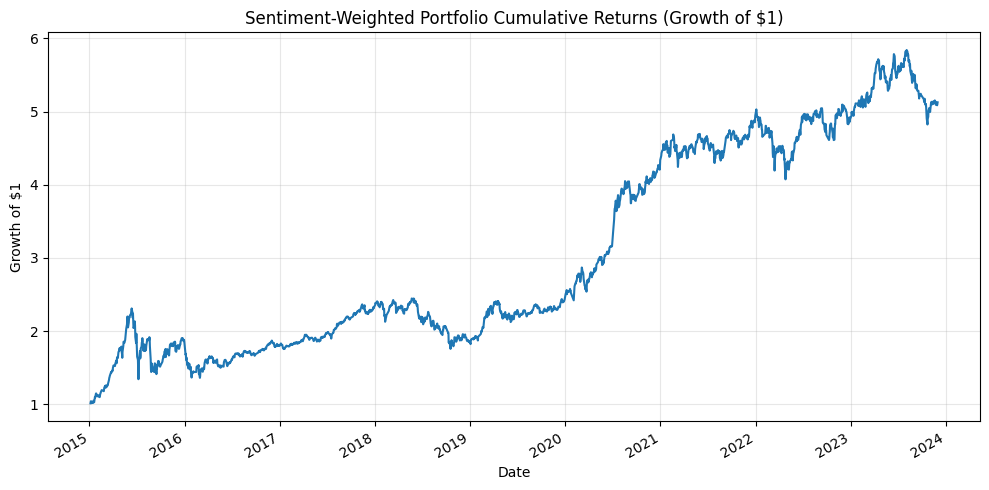

In [55]:
w_name = 'w_ls'

sw_ret = indus_ret_senti.groupby("date").apply(lambda g: (g[w_name] * g["industry_ret"]).sum()).rename("sw_ret")
sw_ret = sw_ret.sort_index()
# Cumulative return (growth of $1)
cum = (1.0 + sw_ret).cumprod().rename("cum_growth")
print(sw_ret.mean() / sw_ret.std() * np.sqrt(243))
# Plot
ax = cum.plot(figsize=(10, 5))
ax.set_title("Sentiment-Weighted Portfolio Cumulative Returns (Growth of $1)")
ax.set_xlabel("Date")
ax.set_ylabel("Growth of $1")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/cm/n391pt213xv2t590fn6lcrph0000gn/T/ipykernel_58837/1333892152.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sw_ret = indus_ret_senti_norm.groupby("date").apply(lambda g: (g["norm_score"] * g["industry_ret"]).sum()).rename("sw_ret")


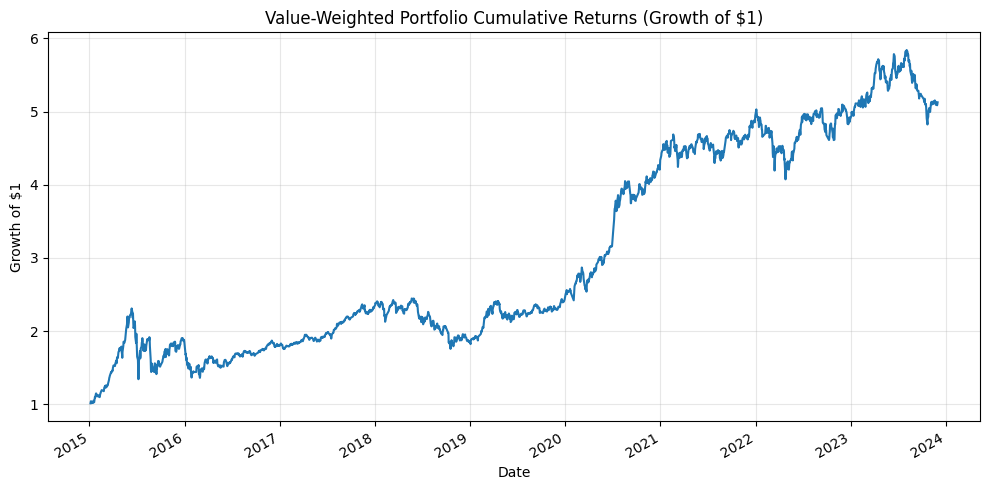

In [56]:
indus_ret_senti_norm = pd.merge(indus_portfolios, sentiments_decay, on=['date', 'industry'], how='inner')
sw_ret = indus_ret_senti_norm.groupby("date").apply(lambda g: (g["norm_score"] * g["industry_ret"]).sum()).rename("sw_ret")
sw_ret = sw_ret.sort_index()
# Cumulative return (growth of $1)
cum = (1.0 + sw_ret).cumprod().rename("cum_growth")
# Plot
ax = cum.plot(figsize=(10, 5))
ax.set_title("Value-Weighted Portfolio Cumulative Returns (Growth of $1)")
ax.set_xlabel("Date")
ax.set_ylabel("Growth of $1")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [57]:
sw_ret.mean() / sw_ret.std()

0.05830771844280062

In [58]:
indus_ret_senti_norm.head()

,date,industry,industry_ret,industry_tot_mv,score,tot_score,norm_score,tail_norm,w_ls
0,2015-01-05,Agriculture,0.013742,5.463158e+07,50,520,0.096154,0.208333,0.096154
1,2015-01-05,Air Transport,0.087998,1.244089e+08,20,520,0.038462,0.083333,0.038462
2,2015-01-05,Animal Husbandry,0.030040,1.186903e+07,0,520,0.000000,-0.000000,0.000000
3,2015-01-05,Art Industry,0.014299,1.425732e+07,30,520,0.057692,0.125000,0.057692
4,2015-01-05,Banking,0.043374,2.493378e+09,0,520,0.000000,-0.000000,0.000000


0.9417088402743704


/var/folders/cm/n391pt213xv2t590fn6lcrph0000gn/T/ipykernel_58837/3678096875.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vw_ret = d.groupby("date", sort=True).apply(lambda g: (g["w"] * g["industry_ret"]).sum()).rename("vw_ret")


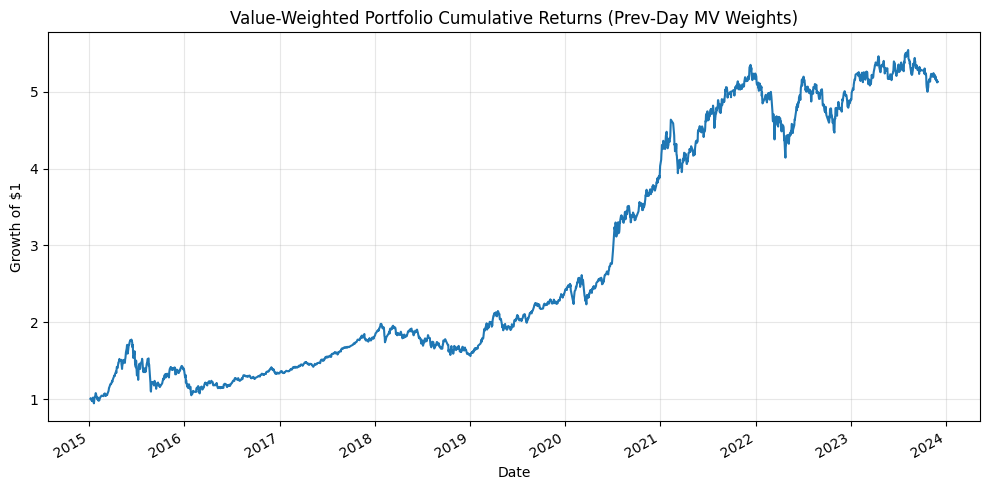

,date,vw_ret,cum_growth
0,2015-01-06,0.005543,1.005543
1,2015-01-07,0.008340,1.013930
2,2015-01-08,-0.019536,0.994121
3,2015-01-09,-0.004385,0.989763
4,2015-01-12,-0.014078,0.975829


In [59]:
def plot_value_weighted_cum_returns(df: pd.DataFrame):
    d = df.copy()

    # Types + cleanup
    d["date"] = pd.to_datetime(d["date"])
    d = d.dropna(subset=["date", "industry", "industry_tot_mv", "industry_ret"])
    d = d.sort_values(["industry", "date"])

    # Use PREV day's MV per industry
    d["prev_mv"] = d.groupby("industry")["industry_tot_mv"].shift(1)

    # Drop first day per industry (no prev mv) and any nonpositive prev_mv
    d = d.dropna(subset=["prev_mv"])
    d = d[d["prev_mv"] > 0]

    # Value weights within each day using prev_mv
    d["day_mv"] = d.groupby("date")["prev_mv"].transform("sum")
    d = d[d["day_mv"] > 0]
    d["w"] = d["prev_mv"] / d["day_mv"]

    # Daily portfolio return = sum_i w_i * r_i
    vw_ret = d.groupby("date", sort=True).apply(lambda g: (g["w"] * g["industry_ret"]).sum()).rename("vw_ret")
    print(vw_ret.mean() / vw_ret.std() * np.sqrt(243))

    # Cumulative return (growth of $1)
    cum = (1.0 + vw_ret).cumprod().rename("cum_growth")

    # Plot
    ax = cum.plot(figsize=(10, 5))
    ax.set_title("Value-Weighted Portfolio Cumulative Returns (Prev-Day MV Weights)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Growth of $1")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return pd.concat([vw_ret, cum], axis=1).reset_index()

# Usage:
out = plot_value_weighted_cum_returns(indus_ret_senti_norm)
out.head()

/var/folders/cm/n391pt213xv2t590fn6lcrph0000gn/T/ipykernel_58837/3737520069.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sw_ret_overnight = d.groupby("date").apply(lambda g: (g[w_name] * g["next_day_ret"]).sum()).rename("sw_ret")


0.946636440807438


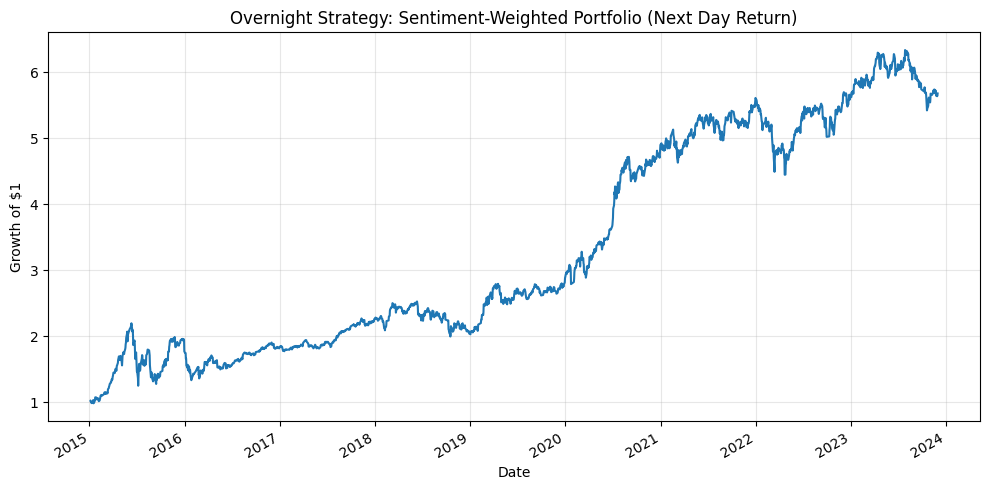

In [ ]:
# Overnight strategy: use today's sentiment weights with next day's return

d = indus_ret_senti.copy().sort_values(['industry', 'date'])
d['next_day_ret'] = d.groupby('industry')['industry_ret'].shift(-1)
d = d.dropna(subset=['next_day_ret', 'w_ls'])

w_name = 'w_ls'
sw_ret_overnight = d.groupby("date").apply(lambda g: (g[w_name] * g["next_day_ret"]).sum()).rename("sw_ret")
sw_ret_overnight = sw_ret_overnight.sort_index()
# Cumulative return (growth of $1)
cum_overnight = (1.0 + sw_ret_overnight).cumprod().rename("cum_growth")
print(sw_ret_overnight.mean() / sw_ret_overnight.std() * np.sqrt(243))
# Plot
ax = cum_overnight.plot(figsize=(10, 5))
ax.set_title("Overnight Strategy: Sentiment-Weighted Portfolio (Next Day Return)")
ax.set_xlabel("Date")
ax.set_ylabel("Growth of $1")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

0.11111690431942513


/var/folders/cm/n391pt213xv2t590fn6lcrph0000gn/T/ipykernel_58837/914990131.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sw_ret_50 = d.groupby("date").apply(lambda g: (g["weight"] * g["next_day_ret"]).sum()).rename("sw_ret")


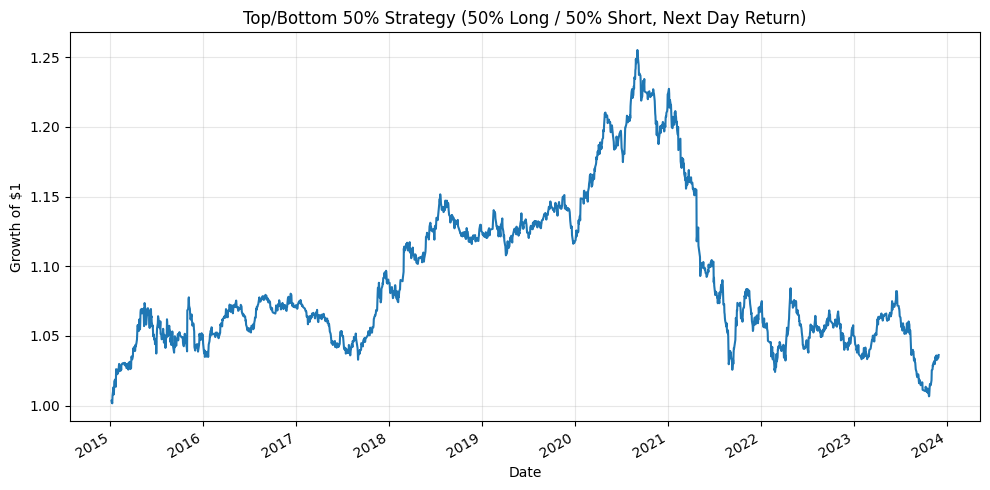

In [62]:
# Top 50% long, bottom 50% short
d = indus_ret_senti.copy()
d["date"] = pd.to_datetime(d["date"])

# rank within each day
d["rank"] = d.groupby("date")["score"].rank(method="first", ascending=False)
d["n"] = d.groupby("date")["score"].transform("count")
d["pct_rank"] = d["rank"] / d["n"]

# top 50% = long, bottom 50% = short
d["position"] = 0
d.loc[d["pct_rank"] <= 0.5, "position"] = 1   # top 50% → long
d.loc[d["pct_rank"] > 0.5, "position"] = -1   # bottom 50% → short

# equal weight within long/short groups
d["n_long"] = d.groupby("date")["position"].transform(lambda x: (x == 1).sum())
d["n_short"] = d.groupby("date")["position"].transform(lambda x: (x == -1).sum())

d["weight"] = 0.0
d.loc[d["position"] == 1, "weight"] = 0.5 / d.loc[d["position"] == 1, "n_long"]
d.loc[d["position"] == -1, "weight"] = -0.5 / d.loc[d["position"] == -1, "n_short"]

# use next day return
d = d.sort_values(["industry", "date"])
d["next_day_ret"] = d.groupby("industry")["industry_ret"].shift(-1)
d = d.dropna(subset=["next_day_ret"])

sw_ret_50 = d.groupby("date").apply(lambda g: (g["weight"] * g["next_day_ret"]).sum()).rename("sw_ret")
sw_ret_50 = sw_ret_50.sort_index()
cum_50 = (1.0 + sw_ret_50).cumprod().rename("cum_growth")
print(sw_ret_50.mean() / sw_ret_50.std() * np.sqrt(243))

ax = cum_50.plot(figsize=(10, 5))
ax.set_title("Top/Bottom 50% Strategy (50% Long / 50% Short, Next Day Return)")
ax.set_xlabel("Date")
ax.set_ylabel("Growth of $1")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

0.05970248937002248


/var/folders/cm/n391pt213xv2t590fn6lcrph0000gn/T/ipykernel_58837/1942281636.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sw_ret_lag = d.groupby("date").apply(lambda g: (g["weight_lag1"] * g["next_day_ret"]).sum()).rename("sw_ret")


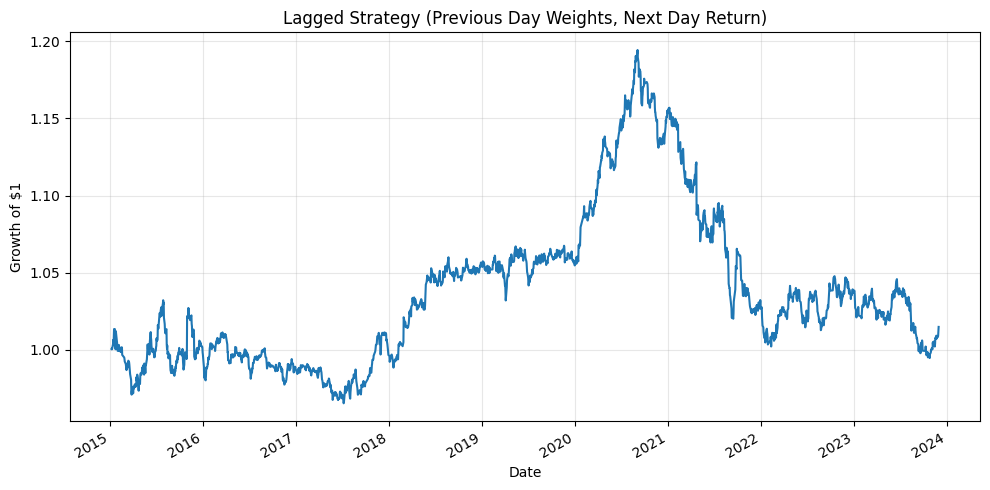

In [63]:
# Same as above but use PREVIOUS day's sentiment weights
d = indus_ret_senti.copy()
d["date"] = pd.to_datetime(d["date"])
d = d.sort_values(["industry", "date"])

# rank within each day
d["rank"] = d.groupby("date")["score"].rank(method="first", ascending=False)
d["n"] = d.groupby("date")["score"].transform("count")
d["pct_rank"] = d["rank"] / d["n"]

# top 50% = long, bottom 50% = short
d["position"] = 0
d.loc[d["pct_rank"] <= 0.5, "position"] = 1
d.loc[d["pct_rank"] > 0.5, "position"] = -1

d["n_long"] = d.groupby("date")["position"].transform(lambda x: (x == 1).sum())
d["n_short"] = d.groupby("date")["position"].transform(lambda x: (x == -1).sum())

d["weight"] = 0.0
d.loc[d["position"] == 1, "weight"] = 0.5 / d.loc[d["position"] == 1, "n_long"]
d.loc[d["position"] == -1, "weight"] = -0.5 / d.loc[d["position"] == -1, "n_short"]

# lag weight by 1 day (use yesterday's sentiment)
d["weight_lag1"] = d.groupby("industry")["weight"].shift(1)

# use next day return
d["next_day_ret"] = d.groupby("industry")["industry_ret"].shift(-1)
d = d.dropna(subset=["next_day_ret", "weight_lag1"])

sw_ret_lag = d.groupby("date").apply(lambda g: (g["weight_lag1"] * g["next_day_ret"]).sum()).rename("sw_ret")
sw_ret_lag = sw_ret_lag.sort_index()
cum_lag = (1.0 + sw_ret_lag).cumprod().rename("cum_growth")
print(sw_ret_lag.mean() / sw_ret_lag.std() * np.sqrt(243))

ax = cum_lag.plot(figsize=(10, 5))
ax.set_title("Lagged Strategy (Previous Day Weights, Next Day Return)")
ax.set_xlabel("Date")
ax.set_ylabel("Growth of $1")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()